# Context

This repo was created to participate in the HuBMAP - Hacking the kidney competition that can be found [here](https://www.kaggle.com/c/hubmap-kidney-segmentation/overview).

# Framing the problem

Our best estimates show there are over 7 billion people on the planet and 300 billion stars in the Milky Way galaxy. By comparison, the adult human body contains 37 trillion cells. To determine the function and relationship among these cells is a monumental undertaking. Many areas of human health would be impacted if we better understand cellular activity. A problem with this much data is a great match for the Kaggle community.

Just as the Human Genome Project mapped the entirety of human DNA, the Human BioMolecular Atlas Program (HuBMAP) is a major endeavor. Sponsored by the National Institutes of Health (NIH), HuBMAP is working to catalyze the development of a framework for mapping the human body at a level of glomeruli functional tissue units for the first time in history. Hoping to become one of the world’s largest collaborative biological projects, HuBMAP aims to be an open map of the human body at the cellular level.

This competition, “Hacking the Kidney," starts by mapping the human kidney at single cell resolution.

Your challenge is to detect functional tissue units (FTUs) across different tissue preparation pipelines. An FTU is defined as a “three-dimensional block of cells centered around a capillary, such that each cell in this block is within diffusion distance from any other cell in the same block” (de Bono, 2013). The goal of this competition is the implementation of a successful and robust glomeruli FTU detector.

You will also have the opportunity to present your findings to a panel of judges for additional consideration. Successful submissions will construct the tools, resources, and cell atlases needed to determine how the relationships between cells can affect the health of an individual.

Advancements in HuBMAP will accelerate the world’s understanding of the relationships between cell and tissue organization and function and human health. These datasets and insights can be used by researchers in cell and tissue anatomy, pharmaceutical companies to develop therapies, or even parents to show their children the magnitude of the human body.

## Supervised evaluation

This competition is evaluated on the mean <strong> Dice coefficient</strong>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

$$\frac{2* | {X}\bigcap{Y} | }{ |X| + |Y|}$$


where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each image in the test set.

Submission File
In order to reduce the submission file size, our metric uses run-length encoding on the pixel values.  Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels .

Note that, at the time of encoding, the mask should be binary, meaning the masks for all objects in an image are joined into a single large mask. A value of 0 should indicate pixels that are not masked, and a value of 1 will indicate pixels that are masked.

The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel , 2 is pixel , etc.

## Desired presentation form note

Participants in this challenge will also have the opportunity to win prize money through the presentation of their submission. After entering the competition, participants can also elect to submit a presentation of their results for review by judges drawn from industry, academia, and government. Top selected submissions will have the opportunity to make a presentation to the judges panel to be evaluated on the below criteria.

### Methodology (50 points) [Scientific Prize]

Are the statistical and modeling methods used to identify glomeruli in the PAS stained microscopy data appropriate for the task?
Are confidence scores and other metrics provided that help interpret the results achieved by the modeling methods?
Did the team validate their methods and algorithm implementations and provide information on algorithm performance and limitations?
Did the team provide any evidence that their method generalizes beyond this immediate task, for example to other FTUs such as alveoli in lungs or crypts in colon?
Did the team document their method and code appropriately?

### Innovation and Applications (30 points) [Innovation Prize]

Did the team develop a creative or novel method to segment glomeruli?
Is the presented characterization of glomeruli useful for understanding individual differences, e.g., the impact of donor sex, age, or weight on the size, shape, or spatial distribution of glomeruli?
Did the team provide insights that would be useful for generating reference glomeruli for inclusion into a Human Reference Atlas?

### Diversity and Presentation (30 points) [Diversity Prize]

Does the team embrace diversity and equity, welcoming team members of different ages, genders, ethnicities, and with multiple backgrounds and perspectives?
Did the authors effectively communicate the details of their method for segmenting glomeruli, and the quality and limitations of their results? For example, did they use data visualizations to present algorithm setup, run, results and/or to provide insight into the comparative performance of different methods? Were these visualizations effective at communicating insights about their approach and results?
Are the important results easily understood by the average person?
Submission Instructions
You can make as many submissions as you like, but we will only consider your latest submission before the deadline of February 1.

All team members must be listed as collaborators on the submitted Notebook, and all team members must accept the competition rules before the submission deadline.

A valid submission will include:

Notebook Analysis: At least one notebook containing the analysis to support your proposal. All notebooks submitted must be made public on or before the submission deadline to be eligible. If submitting as a team, all team members must be listed as collaborators on all notebooks submitted.

# Understanding the objectif

* From kidney images we need to detect and map FTUs

# EDA

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile

In [2]:
BASE_PATH = "../input/hubmap-kidney-segmentation/"
TRAIN_PATH = os.path.join(BASE_PATH, "train")

print(os.listdir(BASE_PATH))

['sample_submission.csv', 'HuBMAP-20-dataset_information.csv', 'train.csv', 'test', 'train']


In [3]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [4]:
df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
9,cb2d976f4.tiff,49548,34940,cb2d976f4-anatomical-structure.json,cb2d976f4.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
6,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45
10,b2dc8411c.tiff,31262,14844,b2dc8411c-anatomical-structure.json,b2dc8411c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45


In [5]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

def read_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_train[df_train["id"] == image_id]["encoding"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask

def read_test_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"test/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image

def plot_image_and_mask(image, mask, image_id):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    
    w_len = image.shape[0]
    h_len = image.shape[1]
    
    min_len = min(w_len, h_len)
    w_start = (w_len - min_len) // 2
    h_start = (h_len - min_len) // 2
    
    plt.imshow(image[w_start : w_start + min_len, h_start : h_start + min_len])
    plt.imshow(
        mask[w_start : w_start + min_len, h_start : h_start + min_len], cmap="hot", alpha=0.5,
    )
    plt.axis("off")
            
    plt.show()
    
def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap="hot")
    plt.axis("off")
    
    plt.show()



In [6]:
small_ids = [
    "0486052bb", "095bf7a1f", "1e2425f28", "2f6ecfcdf",
    "54f2eec69", "aaa6a05cc", "cb2d976f4", "e79de561c",
]
small_images = []
small_masks = []

for small_id in small_ids:
    tmp_image, tmp_mask = read_image(small_id, scale=20, verbose=0)
    small_images.append(tmp_image)
    small_masks.append(tmp_mask)

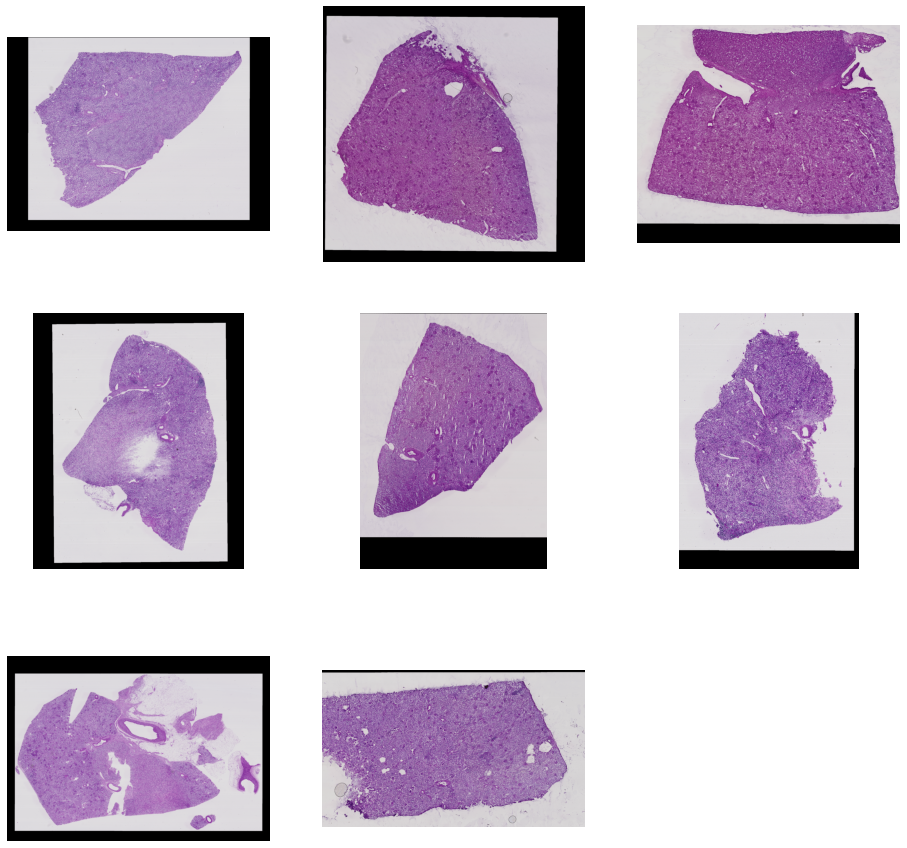

In [7]:
plt.figure(figsize=(16, 16))
for ind, (tmp_id, tmp_image) in enumerate(zip(small_ids, small_images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.axis("off")

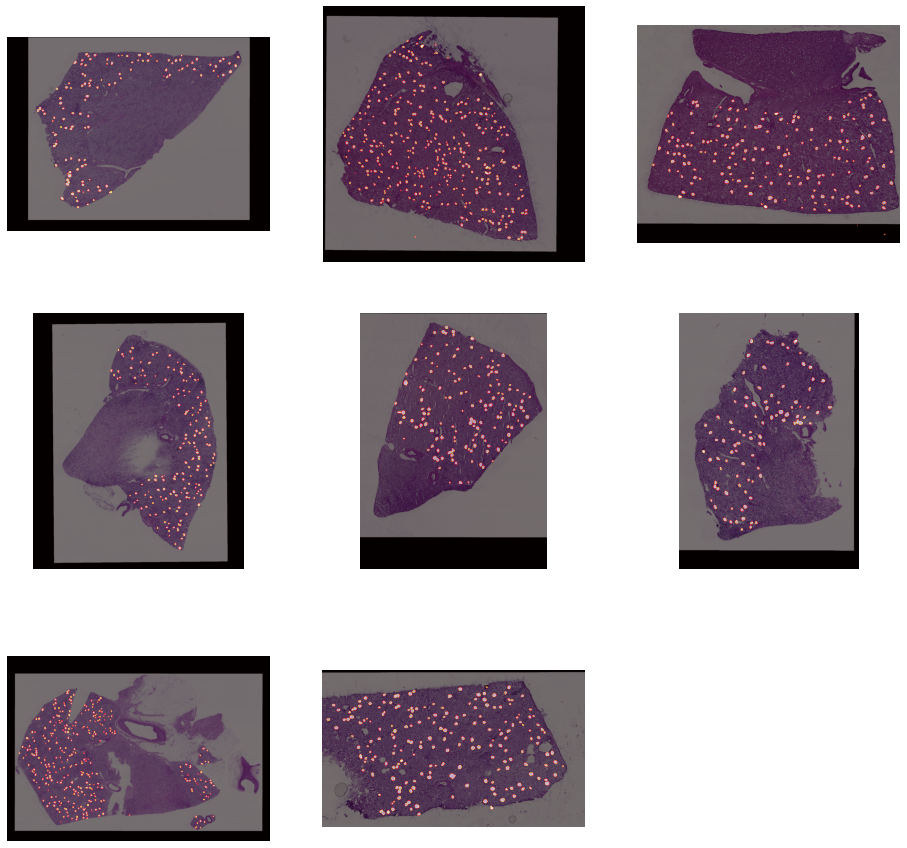

In [8]:
plt.figure(figsize=(16, 16))
for ind, (tmp_id, tmp_image, tmp_mask) in enumerate(zip(small_ids, small_images, small_masks)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.imshow(tmp_mask, cmap="hot", alpha=0.5)
    plt.axis("off")

# Research on data

## The kidney nephron

Each of your kidneys is made up of about a million filtering units called nephrons. Each nephron includes a filter, called the glomerulus, and a tubule. The nephrons work through a two-step process: the glomerulus filters your blood, and the tubule returns needed substances to your blood and removes wastes.

![nephron](https://www.niddk.nih.gov/-/media/Images/Health-Information/Kidney/Nephron_Extraction_330x380.png)

Each nephron has a glomerulus to filter your blood and a tubule that returns needed substances to your blood and pulls out additional wastes. Wastes and extra water become urine.

## The glomerulus filters the blood

As blood flows into each nephron, it enters a cluster of tiny blood vessels—the glomerulus. The thin walls of the glomerulus allow smaller molecules, wastes, and fluid—mostly water—to pass into the tubule. Larger molecules, such as proteins and blood cells, stay in the blood vessel.

![glomerulus](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Renal_corpuscle-en.svg/400px-Renal_corpuscle-en.svg.png)

## How the blood flow through the kidney ?

Blood flows into your kidney through the renal artery. This large blood vessel branches into smaller and smaller blood vessels until the blood reaches the nephrons. In the nephron, your blood is filtered by the tiny blood vessels of the glomeruli and then flows out of your kidney through the renal vein.

Your blood circulates through your kidneys many times a day. In a single day, your kidneys filter about 150 quarts of blood. Most of the water and other substances that filter through your glomeruli are returned to your blood by the tubules. Only 1 to 2 quarts become urine.

![bloodflow](https://www.niddk.nih.gov/-/media/Images/Health-Information/Kidney/Kidney_1_330x315.png)

Blood flows into your kidneys through the renal artery and exits through the renal vein. Your ureter carries urine from the kidney to your bladder.

## The function of filtration

The main function of the glomerulus is to filter plasma to produce glomerular filtrate, which passes down the length of the nephron tubule to form urine. The rate at which the glomerulus produces filtrate from plasma (the glomerular filtration rate) is much higher than in systemic capillaries because of the particular anatomical characteristics of the glomerulus. Unlike systemic capillaries, which receive blood from high-resistance arterioles and drain to low-resistance venules, glomerular capillaries are connected in both ends to high-resistance arterioles: the afferent arteriole, and the efferent arteriole. This arrangement of two arterioles in series determines the high hydrostatic pressure on glomerular capillaries, which is one of the forces that favour filtration to the Bowman's capsule.

If a substance has passed through the glomerular capillary endothelial cells, glomerular basement membrane, and podocytes, then it enters the lumen of the tubule and is known as glomerular filtrate. Otherwise, it exits the glomerulus through the efferent arteriole and continues circulation as discussed below and as shown on the picture.

## Zoom on glomerulus

![](https://www.auanet.org/images/Education/pathology/normal-histology/renal_corpuscle-figureA_Big.jpg)

![](https://www.auanet.org/images/Education/pathology/normal-histology/renal_corpuscle-figureB_Big.jpg)


## Damage on glomerulus

Damage to the glomerulus by disease can allow passage through the glomerular filtration barrier of red blood cells, white blood cells, platelets, and blood proteins such as albumin and globulin. Underlying causes for glomerular injury can be inflammatory, toxic or metabolic. These can be seen in the urine (urinalysis) on microscopic and chemical (dipstick) examination. Examples are diabetic kidney disease, glomerulonephritis, and IgA nephropathy.

Due to the connection between the glomerulus and the glomerular filtration rate, the glomerular filtration rate is of clinical significance when suspecting a kidney disease, or when following up a case with known kidney disease, or when risking a development of renal damage such as beginning medications with known nephrotoxicity.

## Detection methods

Glomerulus classification and detection in kidney tissue segments are key processes in nephropathology used for the correct diagnosis of the diseases. Technics to detect glomerulus involve Convolutional Neural Networks (CNN) between the two classes : Glomerulus and Non-Glomerulus, to detect the image segments belonging to Glomerulus regions.

* Size and shape: In a healthy kidney before sectioning, Glomeruli present a spherical shape with fixed size (diameter ranges between 350 and 100 μm), but its aspect can change due to the presence of medical diseases. For instance: Glomeruli can present a swell aspect under hypertension or diabetes conditions. After sectioning, the presence of pathologies affect the appearance inside the VS. Besides, the different Glomeruli sizes observed could vary depending on where the cross-section was taken with respect to each Glomerulus sphere.

* Color: In some configurations, the use of PAS (Periodic Acid Schiff) stain in tissue sections can give a purple-magenta color to the slides. The amount of stain present in each slide will determine the color intensity of the segments under analysis. Since this process is not perfect, each slide can present different intensities. Moreover, the presence of medical diseases can vary the amount of stain present in the Glomeruli under study.

Glomerulus vs Non-glomerulus

![](https://www.mdpi.com/jimaging/jimaging-04-00020/article_deploy/html/images/jimaging-04-00020-g002.png)


## Conclusions

* Glomerulus are tiny blood vessels that serve as a barrier for the filtration of the plasma.
* Glomerular capillaries are connected in both ends to high-resistance arterioles.
* Damage on glomerulus can be seen in urine tests, microscopic and chemical examinations.
* Glomerular filtration rate is of clinical significance.



# Analysis

# Assumptions

# Data augmentation needs

# Preprocessing

# Models analysis

# Proposed architecture

# Models training

# Hyperparameters

# Evaluation

# Submission

# Github

* https://github.com/MasMedIm/HuBMAP_Kidney.git

# References

* https://atcold.github.io/pytorch-Deep-Learning/en/week03/03-1/
* https://atcold.github.io/pytorch-Deep-Learning/en/week04/04-1/
* https://www.youtube.com/watch?v=AjtX1N_VT9E
* https://www.kaggle.com/ihelon/hubmap-exploratory-data-analysis
* https://www.niddk.nih.gov/health-information/kidney-disease/kidneys-how-they-work#:~:text=Each%20of%20your%20kidneys%20is,your%20blood%20and%20removes%20wastes.
* https://en.wikipedia.org/wiki/Glomerulus_(kidney)
* https://www.mdpi.com/2313-433X/4/1/20/htm


# License 

[Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)
